In [2]:
import json
import folium

# Load the directors international locations data
with open('../data/analysis/directors_international_locations_metadata.json', 'r') as f:
    directors_data = json.load(f)

# Load the geocode cache data
with open('../data/locations/geocode_cache.json', 'r') as f:
    geocode_cache = json.load(f)

def match_location(director_loc, geocode_dict):
    # First, try an exact match
    if director_loc in geocode_dict and geocode_dict[director_loc].get("status") == "OK":
        return geocode_dict[director_loc]
    # Normalize the string for comparison
    director_loc_norm = director_loc.lower().replace(",", "").strip()
    best_match = None
    best_len = 0
    for key, data in geocode_dict.items():
        if data.get("status") != "OK":
            continue
        key_norm = key.lower().replace(",", "").strip()
        # Check if one string is contained in the other
        if key_norm in director_loc_norm or director_loc_norm in key_norm:
            if len(key_norm) > best_len:
                best_match = data
                best_len = len(key_norm)
    return best_match

# Combine the two lists (usa_locations and non_swedish_locations)
all_locations = directors_data.get("usa_locations", []) + directors_data.get("non_swedish_locations", [])

# Build a list of joined records with coordinates
joined_locations = []
for entry in all_locations:
    loc_name = entry.get("location")
    count = entry.get("count", 0)
    geocode = match_location(loc_name, geocode_cache)
    if geocode:
        joined_locations.append({
            "location": loc_name,
            "count": count,
            "latitude": geocode.get("latitude"),
            "longitude": geocode.get("longitude"),
            "formatted_address": geocode.get("formatted_address")
        })
    else:
        # If no match is found, you could log or handle it here.
        print(f"No geocode match found for: {loc_name}")

# If there are joined locations, create a map centered at the mean coordinates:
if joined_locations:
    avg_lat = sum(loc["latitude"] for loc in joined_locations) / len(joined_locations)
    avg_lon = sum(loc["longitude"] for loc in joined_locations) / len(joined_locations)
else:
    # default center if none available
    avg_lat, avg_lon = 0, 0


joined_locations

No geocode match found for: Brussels, Belgium
No geocode match found for: Belgium
No geocode match found for: İstanbul, Türkiye
No geocode match found for: Antwerp, Belgium
No geocode match found for: South Africa
No geocode match found for: Ethiopia
No geocode match found for: Democratic Republic of the Congo
No geocode match found for: Greece
No geocode match found for: Türkiye
No geocode match found for: Syria
No geocode match found for: Reykjavík, Iceland
No geocode match found for: Eyüpsultan/İstanbul, Türkiye
No geocode match found for: Lebanon
No geocode match found for: Ghent, Belgium
No geocode match found for: Piraeus, Greece
No geocode match found for: Estonia
No geocode match found for: Far East
No geocode match found for: Iraq
No geocode match found for: East Africa
No geocode match found for: Libya
No geocode match found for: Indonesia
No geocode match found for: Bulgaria
No geocode match found for: Middle East
No geocode match found for: North Africa
No geocode match fou

[{'location': 'New York, NY, USA',
  'count': 595,
  'latitude': 40.7127753,
  'longitude': -74.0059728,
  'formatted_address': 'New York, NY, USA'},
 {'location': 'United States',
  'count': 298,
  'latitude': 38.7945952,
  'longitude': -106.5348379,
  'formatted_address': 'United States'},
 {'location': 'Washington, DC, USA',
  'count': 112,
  'latitude': 38.9071923,
  'longitude': -77.0368707,
  'formatted_address': 'Washington, DC, USA'},
 {'location': 'Chicago, IL, USA',
  'count': 92,
  'latitude': 41.8781136,
  'longitude': -87.6297982,
  'formatted_address': 'Chicago, IL, USA'},
 {'location': 'San Francisco, CA, USA',
  'count': 44,
  'latitude': 37.7749295,
  'longitude': -122.4194155,
  'formatted_address': 'San Francisco, CA, USA'},
 {'location': '3480 Main Hwy Suite 100, Miami, FL 33133, USA',
  'count': 29,
  'latitude': 25.7616798,
  'longitude': -80.1917902,
  'formatted_address': 'Miami, FL, USA'},
 {'location': 'Pomona, CA, USA',
  'count': 27,
  'latitude': 34.055103,

/Users/jonathanjayes/Documents/PhD/who-is-it/.venv/lib/python3.13/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/jonathanjayes/Documents/PhD/who-is-it/.venv/lib/python3.13/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/jonathanjayes/Documents/PhD/who-is-it/.venv/lib/python3.13/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/jonathanjayes/Documents/PhD/who-is-it/.venv/lib/python3.13/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0

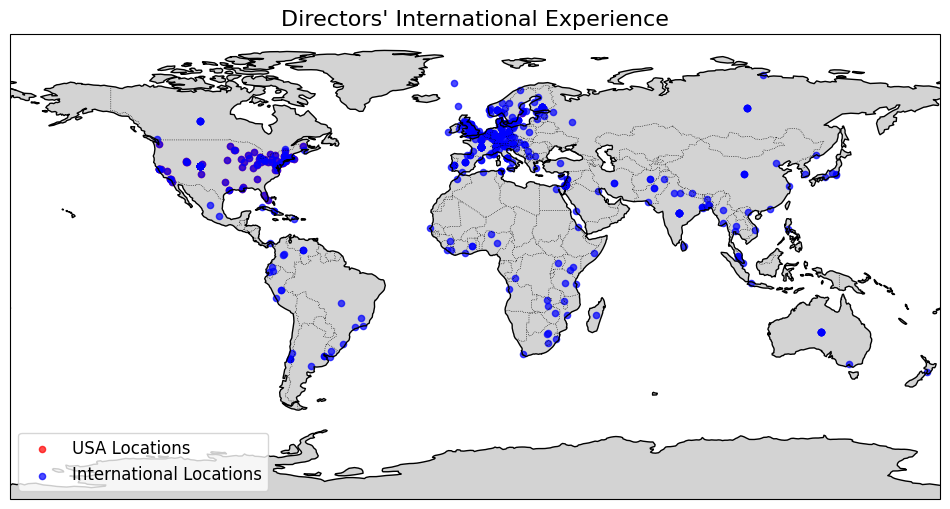

In [5]:
import json
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def match_location(director_loc, geocode_dict):
    # Try an exact match first
    if director_loc in geocode_dict and geocode_dict[director_loc].get("status") == "OK":
        return geocode_dict[director_loc]
    # Normalize strings for a heuristic substring match
    director_loc_norm = director_loc.lower().replace(",", "").strip()
    best_match = None
    best_len = 0
    for key, data in geocode_dict.items():
        if data.get("status") != "OK":
            continue
        key_norm = key.lower().replace(",", "").strip()
        if key_norm in director_loc_norm or director_loc_norm in key_norm:
            if len(key_norm) > best_len:
                best_match = data
                best_len = len(key_norm)
    return best_match

# Process the two sets separately and add an 'is_usa' flag.
joined_locations = []

for entry in directors_data.get("usa_locations", []):
    loc_name = entry.get("location")
    count = entry.get("count", 0)
    geocode = match_location(loc_name, geocode_cache)
    if geocode:
        joined_locations.append({
            "location": loc_name,
            "count": count,
            "latitude": geocode.get("latitude"),
            "longitude": geocode.get("longitude"),
            "formatted_address": geocode.get("formatted_address"),
            "is_usa": True
        })

for entry in directors_data.get("non_swedish_locations", []):
    loc_name = entry.get("location")
    count = entry.get("count", 0)
    geocode = match_location(loc_name, geocode_cache)
    if geocode:
        joined_locations.append({
            "location": loc_name,
            "count": count,
            "latitude": geocode.get("latitude"),
            "longitude": geocode.get("longitude"),
            "formatted_address": geocode.get("formatted_address"),
            "is_usa": False
        })

# Create a static world map using Cartopy
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# Add coastlines, borders, land, and ocean features for context
ax.coastlines(resolution='110m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')

# Separate the USA and international points
usa_lats = [pt['latitude'] for pt in joined_locations if pt['is_usa']]
usa_lons = [pt['longitude'] for pt in joined_locations if pt['is_usa']]
other_lats = [pt['latitude'] for pt in joined_locations if not pt['is_usa']]
other_lons = [pt['longitude'] for pt in joined_locations if not pt['is_usa']]

# Plot the points using different colors and marker sizes
ax.scatter(usa_lons, usa_lats, color='red', s=20, alpha=0.7, transform=ccrs.PlateCarree(), label='USA Locations')
ax.scatter(other_lons, other_lats, color='blue', s=20, alpha=0.7, transform=ccrs.PlateCarree(), label='International Locations')

# Add legend and title for publication-quality aesthetics
plt.legend(loc='lower left', fontsize=12)
plt.title("Directors' International Experience", fontsize=16)

# Save the figure as a high-resolution PNG file
plt.savefig("directors_international_experience_map.png", dpi=300, bbox_inches='tight')
plt.show()

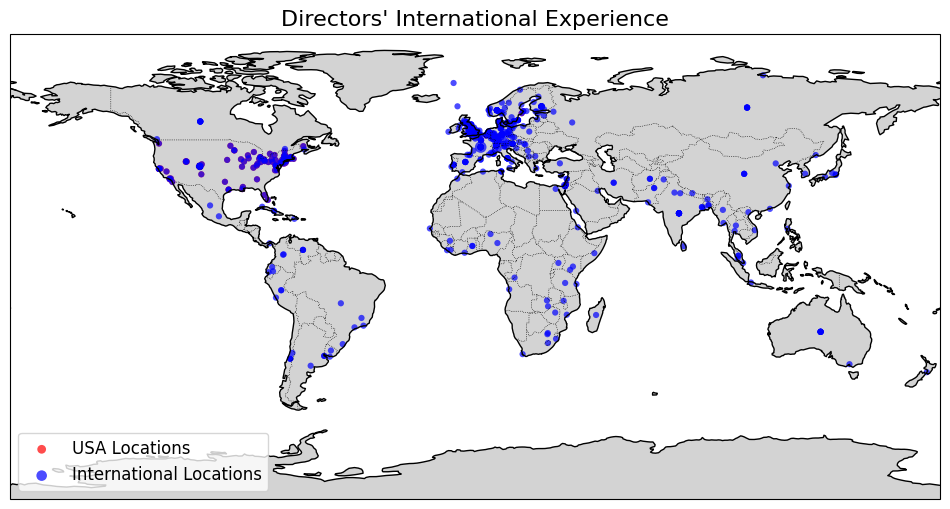

In [7]:

# Load the directors international locations data
with open('../data/analysis/directors_international_locations_metadata.json', 'r') as f:
    directors_data = json.load(f)

# Load the geocode cache data
with open('../data/locations/geocode_cache.json', 'r') as f:
    geocode_cache = json.load(f)



# Process the two sets separately, adding an 'is_usa' flag.
joined_locations = []

for entry in directors_data.get("usa_locations", []):
    loc_name = entry.get("location")
    count = entry.get("count", 0)
    geocode = match_location(loc_name, geocode_cache)
    if geocode:
        joined_locations.append({
            "location": loc_name,
            "count": count,
            "latitude": geocode.get("latitude"),
            "longitude": geocode.get("longitude"),
            "formatted_address": geocode.get("formatted_address"),
            "is_usa": True
        })

for entry in directors_data.get("non_swedish_locations", []):
    loc_name = entry.get("location")
    count = entry.get("count", 0)
    geocode = match_location(loc_name, geocode_cache)
    if geocode:
        joined_locations.append({
            "location": loc_name,
            "count": count,
            "latitude": geocode.get("latitude"),
            "longitude": geocode.get("longitude"),
            "formatted_address": geocode.get("formatted_address"),
            "is_usa": False
        })

# Prepare lists for plotting, scaling the marker size by count.
# Using a scaling factor so that marker sizes remain within a good range.
usa_lats = [pt['latitude'] for pt in joined_locations if pt['is_usa']]
usa_lons = [pt['longitude'] for pt in joined_locations if pt['is_usa']]
usa_sizes = [max(20, pt['count'] / 10) for pt in joined_locations if pt['is_usa']]

other_lats = [pt['latitude'] for pt in joined_locations if not pt['is_usa']]
other_lons = [pt['longitude'] for pt in joined_locations if not pt['is_usa']]
other_sizes = [max(20, pt['count'] / 10) for pt in joined_locations if not pt['is_usa']]

# Create a static world map using Cartopy
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# Add features for a polished, publication-quality map
ax.coastlines(resolution='110m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')

# Plot the points:
# USA locations as filled red circles and international locations as filled blue circles.
ax.scatter(usa_lons, usa_lats, color='red', s=usa_sizes, alpha=0.7,
           transform=ccrs.PlateCarree(), label='USA Locations', edgecolors='none')
ax.scatter(other_lons, other_lats, color='blue', s=other_sizes, alpha=0.7,
           transform=ccrs.PlateCarree(), label='International Locations', edgecolors='none')

# Add legend and title
plt.legend(loc='lower left', fontsize=12)
plt.title("Directors' International Experience", fontsize=16)

# Save the map as a high-resolution PNG file
plt.savefig("directors_international_experience_map.png", dpi=300, bbox_inches='tight')
plt.show()

USA locations count: 135
International locations count: 669
Sample USA location: ['New York, NY, USA', 'United States', 'Washington, DC, USA']
Sample International location: ['London, UK', 'Paris, France', 'New York, NY, USA']


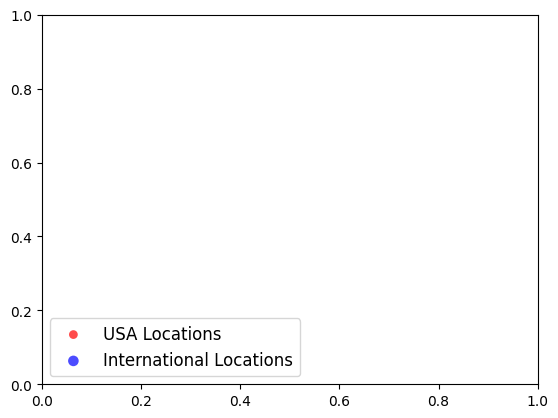

In [8]:
# First, let's check if locations are correctly classified
print(f"USA locations count: {len(usa_lats)}")
print(f"International locations count: {len(other_lats)}")

# These lists should have only locations with is_usa=True and is_usa=False respectively
# Example values from each list to verify:
if usa_lats:
    print(f"Sample USA location: {[pt['location'] for pt in joined_locations if pt['is_usa']][:3]}")
if other_lats:
    print(f"Sample International location: {[pt['location'] for pt in joined_locations if not pt['is_usa']][:3]}")

# Plot the points correctly:
# USA locations as filled red circles and international locations as filled blue circles.
usa_scatter = ax.scatter(usa_lons, usa_lats, color='red', s=usa_sizes, alpha=0.7,
           transform=ccrs.PlateCarree(), label='USA Locations', edgecolors='none')
international_scatter = ax.scatter(other_lons, other_lats, color='blue', s=other_sizes, alpha=0.7,
           transform=ccrs.PlateCarree(), label='International Locations', edgecolors='none')

# For debugging, make sure the legend matches the actual plot colors
plt.legend(handles=[usa_scatter, international_scatter], loc='lower left', fontsize=12)

In [9]:
# Let's check our data structure more closely
print("Checking the 'directors_data' structure:")
print(f"USA locations list length: {len(directors_data.get('usa_locations', []))}")
print(f"Non-Swedish locations list length: {len(directors_data.get('non_swedish_locations', []))}")

# Check for duplicate locations between the two sets
usa_location_names = {entry.get("location") for entry in directors_data.get("usa_locations", [])}
non_swedish_location_names = {entry.get("location") for entry in directors_data.get("non_swedish_locations", [])}
duplicates = usa_location_names.intersection(non_swedish_location_names)
print(f"Duplicate locations found in both sets: {len(duplicates)}")
if duplicates:
    print(f"Example duplicates: {list(duplicates)[:5]}")

# Let's correctly reclassify locations based on the actual country in the formatted address
joined_locations = []

for entry in directors_data.get("usa_locations", []):
    loc_name = entry.get("location")
    count = entry.get("count", 0)
    geocode = match_location(loc_name, geocode_cache)
    if geocode:
        # Check if address actually contains USA
        is_in_usa = any(usa_term in geocode.get("formatted_address", "") 
                        for usa_term in ["USA", "United States", "U.S.A."])
        joined_locations.append({
            "location": loc_name,
            "count": count,
            "latitude": geocode.get("latitude"),
            "longitude": geocode.get("longitude"),
            "formatted_address": geocode.get("formatted_address"),
            "is_usa": is_in_usa,
            "source": "usa_locations"
        })

for entry in directors_data.get("non_swedish_locations", []):
    loc_name = entry.get("location")
    count = entry.get("count", 0)
    geocode = match_location(loc_name, geocode_cache)
    if geocode:
        # Check if address actually contains USA
        is_in_usa = any(usa_term in geocode.get("formatted_address", "") 
                        for usa_term in ["USA", "United States", "U.S.A."])
        joined_locations.append({
            "location": loc_name,
            "count": count,
            "latitude": geocode.get("latitude"),
            "longitude": geocode.get("longitude"),
            "formatted_address": geocode.get("formatted_address"),
            "is_usa": is_in_usa,
            "source": "non_swedish_locations"
        })

# Now redefine the coordinates with the corrected classification
usa_lats = [pt['latitude'] for pt in joined_locations if pt['is_usa']]
usa_lons = [pt['longitude'] for pt in joined_locations if pt['is_usa']]
usa_sizes = [max(20, pt['count'] / 10) for pt in joined_locations if pt['is_usa']]

other_lats = [pt['latitude'] for pt in joined_locations if not pt['is_usa']]
other_lons = [pt['longitude'] for pt in joined_locations if not pt['is_usa']]
other_sizes = [max(20, pt['count'] / 10) for pt in joined_locations if not pt['is_usa']]

Checking the 'directors_data' structure:
USA locations list length: 135
Non-Swedish locations list length: 715
Duplicate locations found in both sets: 135
Example duplicates: ['Lancaster, PA, USA', 'Rydal, PA 19046, USA', 'Stockholm, Sweden', 'Boston, MA, USA', 'Fort Lee, NJ, USA']


Deduplicated USA locations: 126
Deduplicated international locations: 543


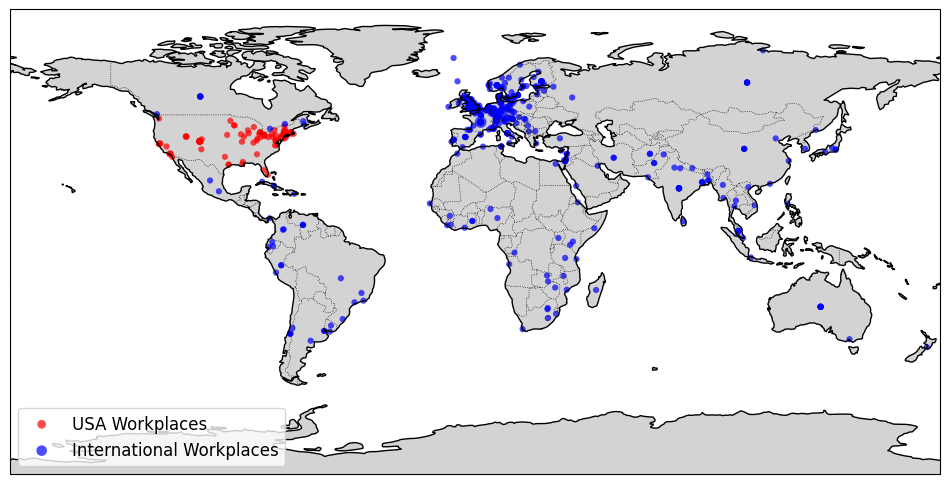

In [11]:
# Create a deduplicated list of locations
joined_locations_deduped = []
processed_locations = set()

# Process USA locations first
for entry in directors_data.get("usa_locations", []):
    loc_name = entry.get("location")
    if loc_name not in processed_locations:
        count = entry.get("count", 0)
        geocode = match_location(loc_name, geocode_cache)
        if geocode:
            # Check if address actually contains USA
            is_in_usa = any(usa_term in geocode.get("formatted_address", "") 
                           for usa_term in ["USA", "United States", "U.S.A."])
            joined_locations_deduped.append({
                "location": loc_name,
                "count": count,
                "latitude": geocode.get("latitude"),
                "longitude": geocode.get("longitude"),
                "formatted_address": geocode.get("formatted_address"),
                "is_usa": is_in_usa
            })
            processed_locations.add(loc_name)

# Then process non-Swedish locations (but skip those already processed)
for entry in directors_data.get("non_swedish_locations", []):
    loc_name = entry.get("location")
    if loc_name not in processed_locations:
        count = entry.get("count", 0)
        geocode = match_location(loc_name, geocode_cache)
        if geocode:
            # Check if address actually contains USA
            is_in_usa = any(usa_term in geocode.get("formatted_address", "") 
                           for usa_term in ["USA", "United States", "U.S.A."])
            joined_locations_deduped.append({
                "location": loc_name,
                "count": count,
                "latitude": geocode.get("latitude"),
                "longitude": geocode.get("longitude"),
                "formatted_address": geocode.get("formatted_address"),
                "is_usa": is_in_usa
            })
            processed_locations.add(loc_name)

# Now redefine the coordinates with the deduplicated locations
usa_lats = [pt['latitude'] for pt in joined_locations_deduped if pt['is_usa']]
usa_lons = [pt['longitude'] for pt in joined_locations_deduped if pt['is_usa']]
usa_sizes = [max(20, pt['count'] / 10) for pt in joined_locations_deduped if pt['is_usa']]

other_lats = [pt['latitude'] for pt in joined_locations_deduped if not pt['is_usa']]
other_lons = [pt['longitude'] for pt in joined_locations_deduped if not pt['is_usa']]
other_sizes = [max(20, pt['count'] / 10) for pt in joined_locations_deduped if not pt['is_usa']]

# Create a new map with the deduplicated data
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# Add features for a polished, publication-quality map
ax.coastlines(resolution='110m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')

# Plot the points with correct colors
usa_scatter = ax.scatter(usa_lons, usa_lats, color='red', s=usa_sizes, alpha=0.7,
           transform=ccrs.PlateCarree(), label='USA Workplaces', edgecolors='none')
international_scatter = ax.scatter(other_lons, other_lats, color='blue', s=other_sizes, alpha=0.7,
           transform=ccrs.PlateCarree(), label='International Workplaces', edgecolors='none')

# Add legend and title
plt.legend(handles=[usa_scatter, international_scatter], loc='lower left', fontsize=12)
# plt.title("Directors' International Experience", fontsize=16)

# Print stats for verification
print(f"Deduplicated USA locations: {len(usa_lats)}")
print(f"Deduplicated international locations: {len(other_lats)}")

# Save the map as a high-resolution PNG file
plt.savefig("directors_international_experience_map.png", dpi=300, bbox_inches='tight')
plt.show()